# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 
Ημερομηνία εκφώνησης της άσκησης: 23 Νοεμβρίου 2020



# Στοιχεία ομάδας

<u>Συνεργάτες</u>

* Δούλης Κωνσταντίνος 03116175

* Καλογερόπουλος Ιωάννης 03116117

* Κατσίκας-Μουρούτσος Γεώργιος 03116132


Αρχικά, ενημερώνουμε τις βιβλιοθήκες που θα χρησιμοποιήσουμε:

In [2]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import warnings
warnings.filterwarnings('ignore')

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [4]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=False)

Κάθε ομάδα θα δουλέψει σε ένα μοναδικό υποσύνολο 5.000 ταινιών (διαφορετικό dataset για κάθε ομάδα) ως εξής

1. Κάθε ομάδα έχει έναν αριθμό "seed" (φύτρο) που είναι ο ίδιος με τον αριθμό της ομάδας σας: θα τον βρείτε στην κολόνα Α/Α [εδώ](https://docs.google.com/spreadsheets/d/1CD6AtX7YnocXceCELl_XJ06kyRr0YQPhor8dpw012t0/edit?usp=sharing).

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Στο επόμενο κελί αλλάξτε τη μεταβλητή `team_seed_number` με το Seed της ομάδας σας.

4. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [5]:
import numpy as np

# βάλτε το seed που αντιστοιχεί στην ομάδα σας
team_seed_number = 67

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1EA_pUIgK5Ub3kEzFbFl8wSRqAV6feHqD"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=99` (την εκατοστή) θα γράψουμε `print(corpus[99])`.

In [6]:
ID = 99
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['Killer Wave']
['"Disaster",  "Thriller"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)

In [8]:
print(corpus_tf_idf.shape)
print(corpus_tf_idf)

(5000, 47943)
  (0, 47172)	0.10636170740253093
  (0, 47001)	0.060664975426296945
  (0, 46984)	0.04450043804022147
  (0, 46745)	0.02515541477638117
  (0, 46664)	0.029662579249770678
  (0, 45925)	0.06543065831693061
  (0, 44984)	0.032445638732630934
  (0, 44884)	0.10347643004790995
  (0, 44155)	0.054874330049076506
  (0, 43669)	0.08061252843604556
  (0, 43495)	0.10918566005071163
  (0, 43201)	0.05291784026897374
  (0, 43167)	0.05688486297522008
  (0, 42818)	0.07367342740946398
  (0, 42711)	0.03548541618735763
  (0, 42705)	0.03058162076023783
  (0, 42689)	0.14582702740060388
  (0, 42019)	0.06156304427775941
  (0, 41615)	0.0826882896413146
  (0, 41599)	0.16221832358962238
  (0, 40912)	0.10636170740253093
  (0, 39812)	0.10099516851967422
  (0, 39521)	0.04234020828274772
  (0, 39324)	0.12485114300372406
  (0, 39281)	0.07908819131303647
  :	:
  (4999, 9355)	0.11460429278874149
  (4999, 8964)	0.1000821731156816
  (4999, 8869)	0.0865397562820995
  (4999, 8583)	0.08145091794457572
  (4999, 6490)

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης. Ανατρέξτε στα notebooks του εργαστηρίου και στο [FAQ](https://docs.google.com/document/d/1hou1gWXQuHAB7J2aV44xm_CtAWJ63q6Cu1V6OwyL_n0/edit?usp=sharing) των ασκήσεων.


Αρχικά κατασκευάζουμε συνάρτηση που θα χρησιμοποιεί την TfidfVectorizer με παραμέτρους που θα δίνονται κατά την κλήση της. Οι παράμετροι αυτοί είναι:

* max_df: Το όριο των ταινιών πάνω από το οποίο αν εμφανίζεται μία λέξη δε θα τη λαμβάνουμε υπόψιν. Με αυτόν τον τρόπο αγνούμε λέξεις που είναι πολύ συχνές και δεν προσφέρουν κάποια πληροφορία που να διαφοροποιεί τις ταινίες μεταξύ τους. Επίσης, με αυτήν την τακτική μειώνεται η διαστατικότητα. Η TfidfVectorizer δέχεται τόσο απόλυτες όσο και ποσοστιαίες τιμές για αυτήν την παράμετρο, ωστόσο παρέχουμε πάντα ποσοστιαία τιμή για το max_df.


* min_df: Το όριο των ταινιών κάτω από το οποίο αν εμφανίζεται μία λέξη δε θα τη λαμβάνουμε υπόψιν. Με αυτόν τον τρόπο αγνούμε λέξεις που έχουν εμφανιστεί πολύ λίγες φορές και επομένως δεν μπορούμε να βασιστούμε πάνω τους, αφού ενδέχεται να οφείλονται σε ορθογραφικά λάθη. Επίσης, με αυτήν την τακτική μειώνεται η διαστατικότητα. Η TfidfVectorizer δέχεται τόσο απόλυτες όσο και ποσοστιαίες τιμές για αυτήν την παράμετρο, ωστόσο παρέχουμε πάντα απόλυτη τιμή για το min_df, δηλαδή αριθμό ταινιών.


* stop_words: Μία λίστα από λέξεις τις οποίες θα αγνοούμε. Τέτοιες λέξεις μπορεί να είναι οι διάφορες συχνές αγγλικές λέξεις, τις οποίες τις αγνοεί απο default η *tf_idf*. Στη συγκεκριμένη εφαρμογή, όπως θα δούμε αργότερα, θα θέτουμε λίστα από λέξεις που απαντώνται συχνά στις πλοκές ταινιών, καθώς επίσης και τα μικρά γυναικεία και αντρικά αγγλικά ονόματα, τα οποία δεν προσθέτουν κάποια πληροφορία.

In [9]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stopwords_english
from sklearn.feature_extraction.text import TfidfVectorizer

def tf_idf(max_df=1.0, min_df=1, stop_words=list()):
    # common english words that will also be ignored
    common_english_stop_words = list(stopwords_english)
    # add to stop words the ones from the parameters
    final_stop_words = stop_words + common_english_stop_words
    # initialize vectorizer with the appropriate parameters
    vectorizer = TfidfVectorizer(max_df = max_df, min_df = min_df, stop_words = final_stop_words)
    # fit
    vectorizer.fit(corpus)
    # transform
    corpus_tf_idf = vectorizer.transform(corpus)

    return corpus_tf_idf

corpus_tf_idf = tf_idf()

## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα παραδώσετε θα είναι μια συνάρτηση `content_recommender` με δύο ορίσματα `target_movie` και `max_recommendations`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, από το `corpus_tf_idf` υπολογίστε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), id, τίτλο, σύνοψη, κατηγορίες (categories)


Αρχικά, υλοποιούμε μία συνάρτηση που θα τυπώνει τις πληροφορίες της κάθε ταινίας:

In [10]:
def print_movie_info(target_movie):
    """
    Function to print information about the
    given movie.
    """
    print("Movie ID: ", target_movie)
    print("Movie title: ", titles[target_movie])
    print("Movie plot: ", corpus[target_movie])
    print("Movie categories: ", categories[target_movie])
    print("="*600)


print_movie_info(0)

Movie ID:  0
Movie title:  ['Paradise Murdered']
Movie plot:  Off the southern coast of the Korean Peninsula, an island of 17 inhabitants exists. The so-called Paradise Island holds up to its name with its breath-taking mountains and sea coupled with good-natured people. No worries or stress holds for anyone who comes to visit this beautiful oasis. But this peace doesn’t last long as every single one of the inhabitants disappear one day without a single trace. Chaos initially breaks out when a blood-drenched corpse is found and everyone becomes a suspect. The furious sea allows them no boat ride to the mainland and their only existing radio communication device has been smashed. Trapped together on the island, everyone is suspicious of each other and even the unseen could be a possible suspect. As hideous secrets get revealed day by day, an island of paradise slowly turns into an island of death.
Movie categories:  ['"Thriller",  "Mystery"']


Παρακάτω υλοποιούμε τη συνάρτηση **content_recommender(target_movie, max_recommendations)** που προτείνει max_recommendations σε πλήθος ταινίες που είναι παρόμοιες με την target movie.

H ομοιότητα των ταινιών προκύπτει με βάση το **cosine similarity** των διανυσμάτων των πλοκών των ταινιών.

Στη συνέχεια, καλούμε τη συνάρτηση αυτή για την πρώτη ταινία ζητώντας τις 5 πιο σχετικές ταινίες.

In [11]:
# import scipy as sp
from sklearn.metrics.pairwise import linear_kernel

def content_recommender(target_movie, max_recommendations):
    """
    Function that recommends max_recommendations movies that are
    similar to target movie.
    """
    
    # get a sorted list of the movies according to cosine similarity with the target movie
    sorted_corpus = sorted(range(corpus_tf_idf.shape[0]), 
                           reverse=True, 
                           key=lambda k: linear_kernel(corpus_tf_idf[target_movie], corpus_tf_idf[k]))

    # print target movie info
    print('\033[1m','\033[36m',"Target Movie", '\033[0m')
    print_movie_info(target_movie)

    # print info of the recommended movies, excluding the first one which is the target movie
    for index, movie in enumerate(sorted_corpus[1:max_recommendations+1]):
        print('\033[1m','\033[36m',index+1, "position", '\033[0m')
        print_movie_info(movie)


content_recommender(0, 5)

  Target Movie 
Movie ID:  0
Movie title:  ['Paradise Murdered']
Movie plot:  Off the southern coast of the Korean Peninsula, an island of 17 inhabitants exists. The so-called Paradise Island holds up to its name with its breath-taking mountains and sea coupled with good-natured people. No worries or stress holds for anyone who comes to visit this beautiful oasis. But this peace doesn’t last long as every single one of the inhabitants disappear one day without a single trace. Chaos initially breaks out when a blood-drenched corpse is found and everyone becomes a suspect. The furious sea allows them no boat ride to the mainland and their only existing radio communication device has been smashed. Trapped together on the island, everyone is suspicious of each other and even the unseen could be a possible suspect. As hideous secrets get revealed day by day, an island of paradise slowly turns into an island of death.
Movie categories:  ['"Thriller",  "Mystery"']
  1 position 
Movie ID:  428

Παρατηρούμε ότι παρότι δεν υπάρχει πλήρης ταύτιση των κατηγοριών των ταινιών οι ταινίες που προκύπτουν δεν είναι τοσο "άσχετες" μεταξύ τους.

## Βελτιστοποίηση

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε τη για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. Μπορείτε επίσης να βελτιστοποιήσετε τη συνάρτηση παρατηρώντας πολλά φαινόμενα που το σύστημα εκλαμβάνει ως ομοιότητα περιεχομένου ενώ επί της ουσίας δεν είναι επιθυμητό να συνυπολογίζονται (δείτε σχετικά το [FAQ](https://docs.google.com/document/d/1hou1gWXQuHAB7J2aV44xm_CtAWJ63q6Cu1V6OwyL_n0/edit?usp=sharing)). Ταυτόχρονα, μια άλλη κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




Σαν πρώτο βήμα για την βελτιστοποίηση της συνάρτησης *tf_idf* είναι ο <u>εμπλουτισμός των stop words</u>. Συγκεκριμένα, μέχρι στιγμής το σύνολο των stopwords περιλαμβάνει μόνο την συνήθεις αγγλικές λέξεις. Επιπλέον σε αυτές θα προσθέσουμε λέξεις που συνδέονται με τον κινηματογράφο και εμφανίζονται συχνά στις πλοκές των ταινιών, καθώς και ένα σύνολο από τα αγγλικά ονόματα, ώστε να αγνοούνται.

In [12]:
import urllib.request 
import string

# words used commonly in film plots, hence will be ignored
film_stop_words = ["movie", "starring", "actor", "actress", "film", "plot", "begins", "opens", "starts", "piece", "named", "woman", "women", "man", "men", "prologue", "help", "helping"]

# english names
female_names_url = "http://www.cs.cmu.edu/Groups/AI/util/areas/nlp/corpora/names/female.txt"
male_names_url = "http://www.cs.cmu.edu/Groups/AI/util/areas/nlp/corpora/names/male.txt"

names = []
for url in [female_names_url, male_names_url]:
    response = urllib.request.urlopen(url).read().decode()
    names = names + [name.lower() for name in response.split('\n') if name and name[0] != "#"]

stop_words = film_stop_words + names

corpus_tf_idf = tf_idf(stop_words=stop_words)
print("Τhe dimensionality of the corpus now is: ", corpus_tf_idf.shape)

content_recommender(4800, 2)

Τhe dimensionality of the corpus now is:  (5000, 44635)
  Target Movie 
Movie ID:  4800
Movie title:  ['Dot the i']
Movie plot:  Carmen, a young Spanish woman who is engaged to be married, has her hen's night at a French restaurant in London. She is invited to participate in the observance of an old custom which allows her to kiss the stranger of her choice before the marriage - symbolically "kissing her single life goodbye" and bringing luck for the future. The man she chooses is Kit and both enjoy the kiss far more than they have intended. They fall in love, which creates a "love triangle" among Carmen, her fiancé Barnaby, and Kit. What initially appears to be a typical urban love story begins to take some surprising and dark twists. In the third act, it is revealed that the circumstances have been arranged in order to create an "emotional snuff film". Unbeknownst to Carmen, she has been cast as the female lead in this endeavor. Barnaby has hired Kit to play a part in the deception, 

In [13]:
content_recommender(666, 3)

  Target Movie 
Movie ID:  666
Movie title:  ['Shadow on the Wall']
Movie plot:  Child Susan Starrling  is the sole witness to a killing, but the shock causes her to suffer amnesia about the event. Her father David  is convicted of first degree murder of his wife. However, psychiatrist Caroline Cranford  is convinced she can cure the young girl and begins to suspect that another person is guilty.
Movie categories:  ['"Mystery",  "Film noir",  "Psychological thriller",  "Black-and-white"']
  1 position 
Movie ID:  4027
Movie title:  ['Eyes Beyond Seeing']
Movie plot:  An enigmatic, homeless mental patient  who claims to be the second coming of Jesus Christ has recently been once again committed. He begins to suffer asylum life. Despite this, he befriends his psychiatrist who has lost his faith, and the man manages to change the psychiatrist's life.
Movie categories:  ['"Drama"']
  2 position 
Movie ID:  4628
Movie title:  ['Steamboat Round the Bend']
Movie plot:  A con man enters his st

Ως μία μετρική για το για ποια ταινία προτάθηκαν οι σχετικότερες με αυτήν ταινίες, θεωρούμε το πλήθος των κατηγοριών αυτής που αποτελούν κατηγορίες και για τις προτεινόμενες για αυτήν ταινίες. 

Επομένως, για την κάθε ταινία που εξετάζουμε βρίσκουμε τις 3 πιο κοντινές, με βάση το $cosine similarity$ και στη συνέχεια για καθεμία από τις 3 ταινίες υπολογίζουμε το:

**πλήθος κοινών κατηγοριών με την target movie δια πλήθος κατηγοριών της target movie**

Στη συνέχεια υπολογίζουμε τον μέσο όρο του παραπάνω κλάσματος και για τις 3 ταινίες που προτάθηκαν και επαναλαμβάνουμε για κάθε ταινία που εξετάζουμε.

Στο τέλος ταξινομούμε τις ταινίες με βάση τον μέσο όρο των κλασμάτων. Η βελτιστοποίηση των παραμέτρων της συνάρτησης tf_idf θα γίνει με βάση τις ταινίες που θα σημειώσουν τα υψηλότερα ποσοστά στην παραπάνω διαδικασία.



Παρακάτω υλοποιείται μία συνάρτηση που έχει ως σκοπό τη γραφική απεικόνιση της προόδου, που θα χρησιμοποιείται συχνά παρακάτω:

In [14]:
from IPython.display import HTML, display
import time

def progress(value, max=50):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [15]:
import random

def similar_categories(max_recommendations, movies_to_check=range(len(titles)), sort=True, showProgress=True):
    """
    Function that takes as arguments:
    
    * max_recommendations: the number of the movies that will be recommended for each target movie
    * movies_to_check: a list of the id's of the movies that will be used as target movies
    * sort: Boolean variable that defines if the result will be sorted or not
    * showProgress: Boolean variable that defines if the function similar_categories will print its progress
    
    Returns a sorted (or not) list of the movies_to_check with the achieved score, sorted be the score.
    """
    
    best_movies = []
    # print(corpus_tf_idf.shape)
    if showProgress:
        # cnt for progress bar
        cnt = 0
        out = display(progress(0, len(movies_to_check)), display_id=True)
    # for every movie
    for movie in movies_to_check:
        # get sorted array of indexes accoring to the cosine similarity
        cosine_similarity_sorted = sorted(range(corpus_tf_idf.shape[0]), reverse=True, key=lambda k: linear_kernel(corpus_tf_idf[movie], corpus_tf_idf[k]))
        # split the categories of each movie and add the to a list
        movie_categories = set([cat[1:-1] for cat in categories[movie][0].split(',  ')])
        
        sum = 0
        for similar_movie in cosine_similarity_sorted[1:max_recommendations+1]:
            # for each similar movie get a set of its categories
            similar_movie_categories = set([cat[1:-1] for cat in categories[similar_movie][0].split(',  ')])
            # get the sum of all the scores. 
            # Score is computed by the intersection of the recommended movie's categories and the 
            # target movie's categories divided by the number of the categories of the target movies.
            sum += len(movie_categories.intersection(similar_movie_categories)) / len(movie_categories)
        
        # get the mean of all the scores
        mean = sum / max_recommendations
        best_movies.append((movie, mean))
        if showProgress: 
            cnt += 1
            out.update(progress(cnt, len(movies_to_check)))

    # sort
    if sort:
        best_movies.sort(key=lambda tup: tup[1], reverse=True)
    # progress bar
    return best_movies

# get 100 random movies from our list
hundred_random_movies = [i for i in random.sample(range(0,5001), 100)]

best_movies = similar_categories(max_recommendations=3, movies_to_check=hundred_random_movies)

Επομένως, με την εκτέλεση των παραπάνω έχουμε βρει ανάμεσα σε 100 τυχαίες ταινίες ποιες από αυτές έχουν σημειώσει τα καλύτερα σκορ. Η βελτιστοποίηση θα γίνει με τις πρώτες ταινίες της ταξινομημένης λίστας που έχει προκύψει. Ο αριθμός των ταινιών που ελέγξαμε δεν είναι μεγάλος συγκριτικά με το πλήθος όλων των ταινιών ωστόσο τα αποτελέσματα ήταν αρκετά ικανοποιητικά.

In [19]:
import joblib

joblib.dump(best_movies, 'best_movies.pkl') 

['best_movies.pkl']

In [18]:
best_movies = joblib.load('best_movies.pkl') 

Επιλέγοντας τις 10 πρώτες ταινίες που είχαν το καλύτερο ποσοστό κατηγοριών στις προτεινόμενες για αυτές ταινίες έχουμε:

In [20]:
print(best_movies[:10])

[(3516, 0.8571428571428571), (1053, 0.6666666666666666), (802, 0.6666666666666666), (2744, 0.6666666666666666), (4723, 0.6666666666666666), (3145, 0.6666666666666666), (4054, 0.6666666666666666), (4976, 0.6666666666666666), (833, 0.6666666666666666), (2704, 0.6666666666666666)]


Εκτελούμε την content_recommender για την ταινία με το καλύτερο σκορ και για max_recommendations=10:

In [21]:
corpus_tf_idf = tf_idf(stop_words=stop_words)
content_recommender(3516, 10)
similar_categories(max_recommendations=10, movies_to_check=[3516])

  Target Movie 
Movie ID:  3516
Movie title:  ['Godzilla: Final Wars']
Movie plot:   Endless warfare and environmental pollution has resulted in dangerous kaiju and the Earth Defense Force  is created to protect the planet. The organization is equipped with the best technology, weapons and soldiers, as well as mutants with special abilities. Godzilla is the EDF's only unstoppable opponent. The EDF's best combat vehicle, the Gotengo, corners Godzilla at the South Pole and buries him under the Antarctic ice, freezing him alive. Several years later, the EDF discovers a mummified space monster. Mutant soldier Shinichi Ozaki and United Nations biologist Dr. Miyuki Otonashi are sent to research it. Shortly thereafter, the two encounter the Shobijin, fairies of the guardian monster Mothra, who reveal that the monster is Gigan, an alien cyborg sent to destroy Earth 12,000 years earlier. They also warn that a battle between good and evil will happen soon. Monsters appear in major cities on Eart

[(3516, 0.41428571428571426)]

Παρατηρούμε ότι οι περισσότερες από τις 10 ταινίες που προτάθηκαν ανήκουν στην κατηγορία *Science Fiction*. Ωστόσο, παρατηρούμε ότι το ποσοστό των κατηγοριών της target movie που ανήκουν και σε αυτές που προτάθηκαν είναι μειωμένο (41.4% έναντι 85.7%). Αυτό είναι λογικό, αφού αφενός έχουμε πλέον μεγαλυτερο δείγμα ταινιών και αφετέρου οι πρώτες ταινίες που προτάθηκαν ανήκουν στην ίδια σειρά ταινιών. Αξίζει ωστόσο να σημειώσουμε ότι το ποσοστό αυτό δεν είναι πολύ μακριά από το 2ο καλύτερο ποσοστό όταν προτείναμε 3 μόνο ταινίες (66.6%).

### Max_df

Στη συνέχεια, θα πειραματιστούμε με την μείωση της διαστατικότητας αφαιρώντας λέξεις που εμφανίζονται αρκετά συχνά. Η default παράμετρος που έχει χρησιμοποιποιηθεί μέχρι στιγμής είναι 1.0, που δηλώνει ότι δε θα αγνοούνται καθόλου λέξεις όσο συχνές και να είναι. Επομένως, θα δοκιμάσουμε να μειώσουμε το κατώφλι πάνω από το οποίο οι λέξεις θα αγνοούνται. Οι δοκιμές αυτές θα γίνουν πάνω στις 20 πρώτες ταινίες με τα καλύτερα αποτελέσματα στην παραπάνω μετρική. Αρχικά έγιναν και δοκιμές χρησιμοποιώντας περισσότερες τιμές για την μεταβλητή max_df χρησιμοποιώντας λιγότερες ταινίες. Όταν η περιοχή των βέλτιστων τιμών περιορίστηκε δοκιμάστηκαν περισσότερες ταινίες.

In [189]:
max_dfs = np.insert(np.arange(1,10,1)/10, 0, 0.05, axis=0)
max_df_scores_many = {}
cnt = 0
out = display(progress(cnt, 20), display_id=True)
for movie in best_movies[:20]:
    max_df_scores_many[movie[0]] = []
    for max_df in max_dfs:
        corpus_tf_idf = tf_idf(max_df=max_df, stop_words=stop_words)
        max_df_scores_many[movie[0]].append(similar_categories(max_recommendations=10, movies_to_check=[movie[0]], sort=False, showProgress=False))
    cnt+=1
    out.update(progress(cnt, 20))

In [ ]:
max_dfs = np.append(np.arange(5,101,5)/1000, np.arange(2,10,1)/10)
max_df_scores = {}
cnt = 0
out = display(progress(cnt, 10), display_id=True)
for movie in best_movies[:10]:
    # print('\033[1m',movie[0],'\033[0m')
    max_df_scores[movie[0]] = []
    for max_df in max_dfs:
        # print('\033[1m',"max_df = ",max_df,'\033[0m')
        corpus_tf_idf = tf_idf(max_df=max_df, stop_words=stop_words)
        # content_recommender(1053, 10)
        max_df_scores[movie[0]].append(similar_categories(max_recommendations=10, movies_to_check=[movie[0]], sort=False, showProgress=False))
    cnt+=1
    out.update(progress(cnt, 10))

### Min_df

Ακολούθως, θα πειραματιστούμε με την μείωση της διαστατικότητας αφαιρώντας λέξεις που εμφανίζονται αρκετά σπάνια. Η default τιμή που έχει χρησιμοποιποιηθεί μέχρι στιγμής για την παράμετρο min_df είναι 1, που δηλώνει ότι δε θα αγνοούνται καθόλου λέξεις, όσο σπάνιες και να είναι. Επομένως, θα δοκιμάσουμε να αυξήσουμε το κατώφλι αυστήρά κάτω από το οποίο οι λέξεις θα αγνοούνται. Οι δοκιμές αυτές θα γίνουν πάνω στις 20 πρώτες ταινίες με τα καλύτερα αποτελέσματα στην παραπάνω μετρική. Αρχικά έγιναν και δοκιμές χρησιμοποιώντας μεγαλύτερο εύρος τιμών για την μεταβλητή min_df χρησιμοποιώντας λιγότερες ταινίες. Όταν η περιοχή των βέλτιστων τιμών περιορίστηκε δοκιμάστηκαν περισσότερες ταινίες.

In [195]:
min_dfs = np.arange(1,11)
min_df_scores = {}
cnt = 0
out = display(progress(cnt, 20), display_id=True)
# for each of the first 5 movies
for movie in best_movies[:20]:

    min_df_scores[movie[0]] = []
    # for each value of min_df
    for min_df in min_dfs:
        # create tf_idf
        corpus_tf_idf = tf_idf(min_df=min_df, stop_words=stop_words)
        min_df_scores[movie[0]].append(similar_categories(max_recommendations=10, movies_to_check=[movie[0]], sort=False, showProgress=False))
    cnt+=1
    out.update(progress(cnt, 20))

Παρακάτω ακολουθούν βοηθητικές συναρτήσεις που θα αναλάβουν την γραφική αναπαράσταση των παραπάνω αποτελεσμάτων:

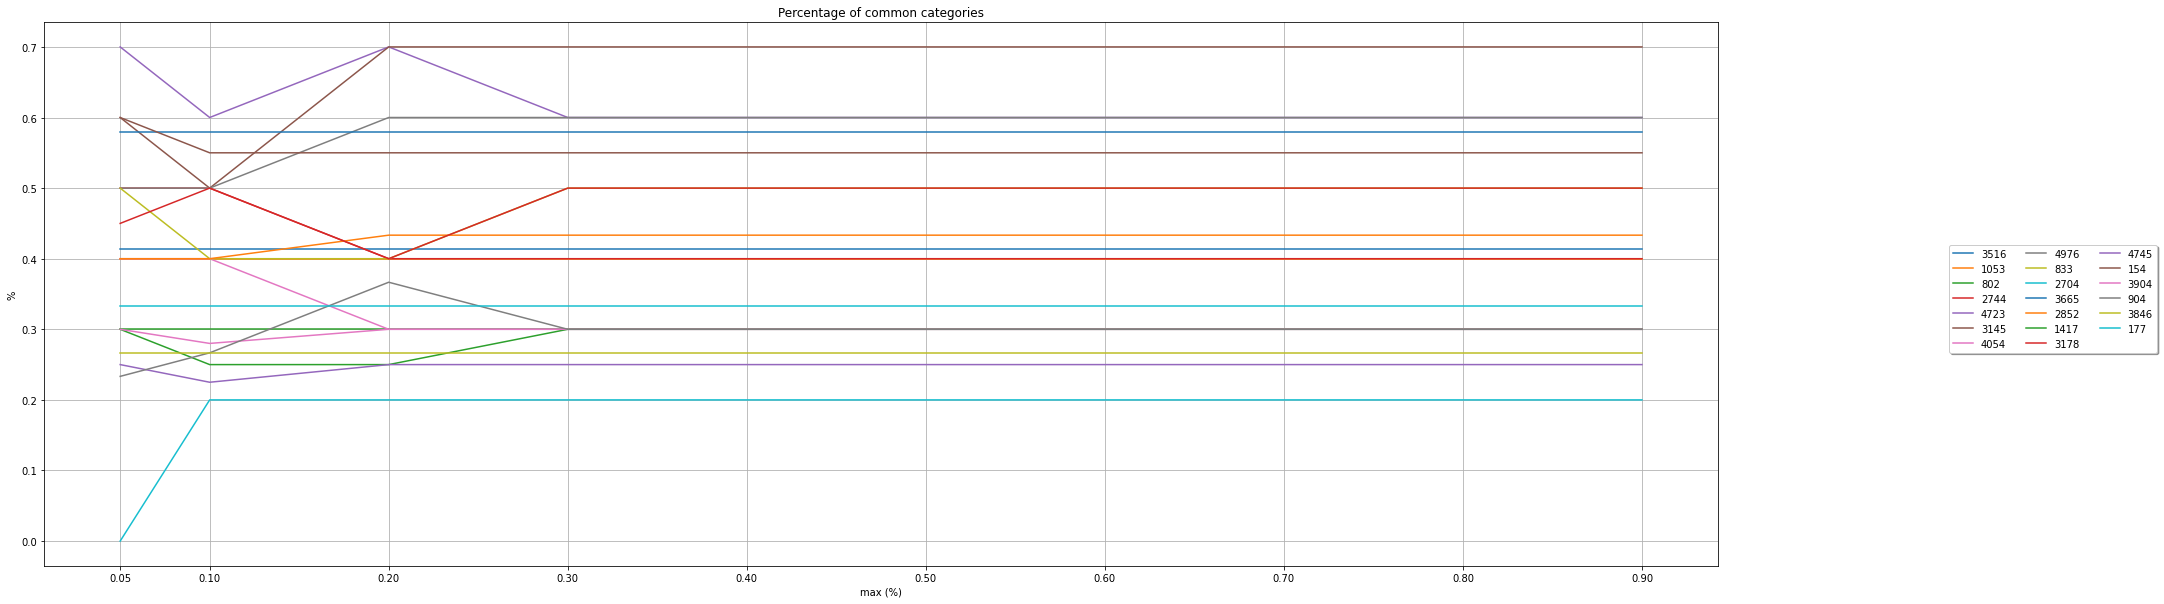

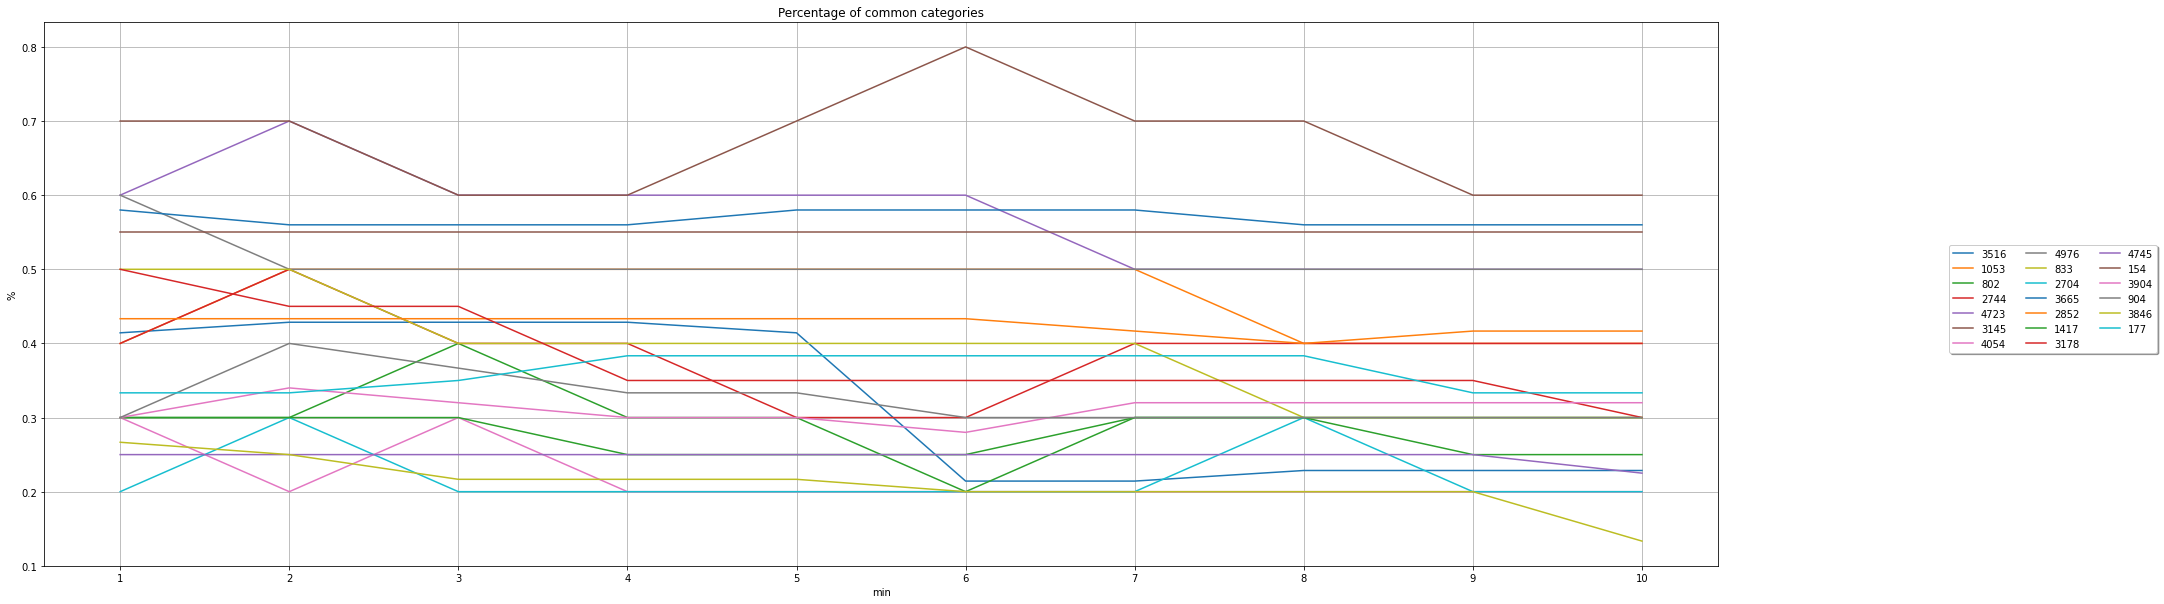

In [196]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotScores(xaxis, scores, x_label):
    plt.figure(figsize=(30,10))
    for movie in scores:
        plt.plot(xaxis,scores[movie])
    plt.xlabel(x_label)
    plt.ylabel('%')
    plt.xticks(xaxis)
    plt.title('Percentage of common categories')
    plt.legend(scores.keys(), loc='upper center', bbox_to_anchor=(1.2, 0.6),
          ncol=3, fancybox=True, shadow=True)
    plt.grid(True)
    plt.savefig(x_label+".png")
    plt.show()



min_y_axes = {}
max_y_axes = {}
for movie in min_df_scores:
    min_y_axes[movie] = [score[0][1] for score in min_df_scores[movie]]
    max_y_axes[movie] = [score[0][1] for score in max_df_scores_many[movie]]
plotScores(max_dfs, max_y_axes, 'max (%)')
plotScores(min_dfs, min_y_axes, 'min')

Από τα παραπάνω είναι φανερό ότι οι τιμές που θα επιλεγούν ως παράμετροι για το tf-idf είναι:

* max_df = $0.3$
* min_df = $2$

Τα παραπάνω μεταφράζονται στο ότι θα αγνοούνται οι λέξεις που εμφανίζονται σε πλοκές λιγότερο από 2 δύο ταινιών, δηλαδή οι όροι που υπάρχουν στην πλοκή μίας μόνο ταινίας, ενώ δε θα λαμβάνονται υπόψιν και οι λέξεις που εμφανίζονται παραπάνω από το 30% των  πλοκών των ταινιών.

In [22]:
opt_max_df=0.3
opt_min_df=2
corpus_tf_idf = tf_idf(max_df=opt_max_df, min_df=opt_min_df, stop_words=stop_words)
# content_recommender(1053, 10)
print(similar_categories(max_recommendations=10, movies_to_check=[3516]))

[(3516, 0.42857142857142855)]


In [ ]:
corpus_tf_idf = tf_idf(stop_words=stop_words)
# content_recommender(1053, 10)
print(similar_categories(max_recommendations=10, movies_to_check=[3516]))

1.0
(5000, 44635)
(5000, 44635)


[(3516, 0.41428571428571426)]


Στη συνέχεια θα αναπαραστήσουμε γραφικά τα αποτελέσματα για τις 10 πρώτες ταινίες, όπως ταξινομήθηκαν με βάση τη μετρική που αναφέραμε παραπάνω. Τα αποτελέσματα θα συγκριθούν με αυτά που θα είχαμε με τις default παραμέτρους, ενώ θα συγκρίνουμε και τη μεταβολή της διαστατικότητας:

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_results(def_scores, opt_scores):
    n_groups = len(def_scores)
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    def_values = [movie[1] for movie in def_scores]
    print(def_values)
    rects1 = plt.bar(index, def_values, bar_width,
                    alpha=opacity,
                    color='b',
                    label='Default')
    
    
    
    opt_values = [movie[1] for movie in opt_scores]
    print(opt_values)
    rects2 = plt.bar(index + bar_width, opt_values, bar_width,
                    alpha=opacity,
                    color='g',
                    label='Optimized')

    # fig.set_size_inches(10, 10)
    plt.xlabel('Movie')
    plt.ylabel('Percentage')
    plt.title('Percentage of common categories')
    movie_titles = [movie[0] for movie in def_scores]
    plt.xticks(index + bar_width/2, movie_titles)
    plt.legend()
    plt.ylim(0, 1)
    plt.grid(True)


    plt.tight_layout()
    plt.show()

def plot_dimensionality(dim1, dim2):
    index = range(2)
    bar_width = 0.35
    opacity = 0.8
    data = [dim1, dim2]
    print(data)
    plt.bar(['Default','Optimized'], data, bar_width, alpha=opacity, color='pink')
    # plt.xticks(['Default','Optimized'])
    # plt.legend()
    # plt.ylim(0, 1)
    plt.grid(True)


    plt.tight_layout()
    plt.show()

[0.41428571428571426, 0.4, 0.3, 0.4, 0.6, 0.7, 0.3, 0.6, 0.5, 0.2]
[0.42857142857142855, 0.5, 0.3, 0.5, 0.7, 0.7, 0.2, 0.5, 0.5, 0.3]


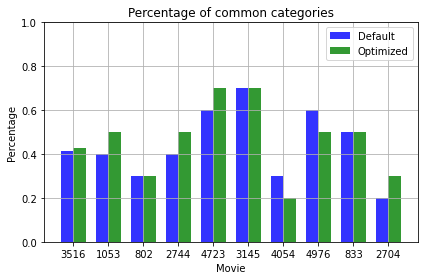

[44635, 22150]


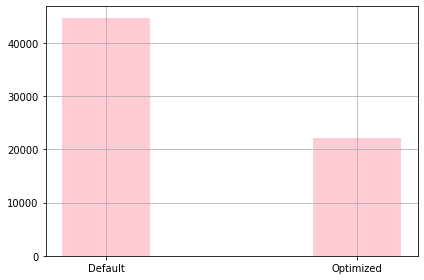

In [26]:
def test_results(max_rec=10, recommend=False):
    
    movies_for_check = [movie[0] for movie in best_movies[:10]]
    
    # check for the first 10 movies
    # print("corpus_tf_idf.shape: ", corpus_tf_idf.shape)
    if recommend:
        for movie_id in movies_for_check:
            content_recommender(movie_id, max_rec)
    

    scores = similar_categories(max_recommendations=max_rec, movies_to_check=movies_for_check, sort=False)
    
    return scores



# default tf_idf
corpus_tf_idf = tf_idf(stop_words=stop_words)
def_dim = corpus_tf_idf.shape[1]
# test default
def_scores = test_results(recommend=False)
# optimized tf_idf
corpus_tf_idf = tf_idf(max_df=opt_max_df, min_df=opt_min_df, stop_words=stop_words)
opt_dim = corpus_tf_idf.shape[1]
# test_optimized
opt_scores = test_results(recommend=False)
# plot results
plot_results(def_scores, opt_scores)
# plot dimensionalities
plot_dimensionality(def_dim, opt_dim)

In [201]:
print(corpus_tf_idf.shape)

(5000, 22136)


## Επεξήγηση επιλογών και ποιοτική ερμηνεία

Σε markdown περιγράψτε πώς προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. Επίσης σε markdown δώστε 10 παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (5 και παραπάνω) και σημειώστε συνοπτικά ποια είναι η θεματική που ενώνει τις ταινίες.

Δείτε [εδώ](https://pastebin.com/raw/ZEvg5t3z) ένα παράδειγμα εξόδου του βελτιστοποιημένου συστήματος συστάσεων για την ταίνία ["Q Planes"](https://en.wikipedia.org/wiki/Q_Planes) με την κλήση της συνάρτησης για κάποιο seed `content_recommender(529,3)`. Είναι φανερό ότι η κοινή θεματική των ταινιών είναι τα αεροπλάνα, οι πτήσεις, οι πιλότοι, ο πόλεμος.

Η ανάλυση για τη διαδικασία βελτιστοποίησης της TfidfVectorizer περιγράφηκε παραπάνω, για κάθε παράμετρο ξεχωριστά. Παρακάτω ακολουθούν τα recommendations των 10 ταινιών που επιστρέφουν τα καλύτερα αποτελέσματα, με πλήθος προτάσεων ίσο με 7:

In [24]:
content_recommender(best_movies[0][0], 7)

  Target Movie 
Movie ID:  3516
Movie title:  ['Godzilla: Final Wars']
Movie plot:   Endless warfare and environmental pollution has resulted in dangerous kaiju and the Earth Defense Force  is created to protect the planet. The organization is equipped with the best technology, weapons and soldiers, as well as mutants with special abilities. Godzilla is the EDF's only unstoppable opponent. The EDF's best combat vehicle, the Gotengo, corners Godzilla at the South Pole and buries him under the Antarctic ice, freezing him alive. Several years later, the EDF discovers a mummified space monster. Mutant soldier Shinichi Ozaki and United Nations biologist Dr. Miyuki Otonashi are sent to research it. Shortly thereafter, the two encounter the Shobijin, fairies of the guardian monster Mothra, who reveal that the monster is Gigan, an alien cyborg sent to destroy Earth 12,000 years earlier. They also warn that a battle between good and evil will happen soon. Monsters appear in major cities on Eart

Σύμφωνα με τα αποτελέσματα για την ταινία **Godzilla: Final Wars** προτάθηκαν οι εξής 7 ταινίες:

1. Godzilla vs. Hedorah
2. Ghidorah, the Three-Headed Monster
3. Godzilla Against Mechagodzilla
4. Mothra vs. Godzilla
5. Mystery Monsters
6. Scooby-Doo and the Loch Ness Monster
7. Journey to Saturn

Μελετώντας τις κατηγορίες και τις πλοκές των παραπάνω ταινιών, συμπεραίνουμε ότι προτάθηκαν ταινίες που ανήκουν στην πλειψηφία τους στην κατηγορία *Science Fiction*. Σημαντικό είναι να σημειώσουμε ότι η ταινία target_movie αποτελεί μέρος της σειράς των ταινιών με τον **Godzilla**, επομένως οι πρώτες τέσσερεις ταινίες ανήκουν και αυτές στην ίδια σειρά ταινιών και έχουν τις ίδιες κατηγορίες. Αυτός ήταν μάλλον και ο λόγος που η ταινία Godzilla: Final Wars σημείωσε το καλύτερο σκορ στη μετρική που είχαμε, ενώ οι άλλες ταινίες της σειράς δεν υπήρχαν στα 100 τυχαία δείγματα που πήραμε από τις 5000 ταινίες. Οι υπόλοιπες ταινίες που προτάθηκαν παρότι δεν έχουν *όλες* τους τις κατηγορίες κοινές, ανήκουν στο ίδιο στυλ ταινιών, δηλαδή ταινιών επιστημονικής φαντασίας με τέρατα και δράση.

In [25]:
content_recommender(best_movies[1][0], 7)

  Target Movie 
Movie ID:  1053
Movie title:  ['Bahurani']
Movie plot:  The Zamindar  has two sons - Raghu, by his first wife, and Vikram, by his second wife. Raghu  is a simple-minded and innocent young man. Vikram  is cruel, domineering, selfish and greedy, and he maltreats everyone, from servants to his own brother Raghu. Vikram's vicious mother  does the same. After Vikram has a feud with a tough and smart village girl named Padma , who is the first person to ever confront him, Zamindar gets an idea of marrying Vikram and Padma. Vikram refuses, and after a series of incidents, Padma ends up getting married to Raghu instead. When she understands how her husband has been treated over the years, she vows to set things right, and in the process falls in love with him. Inspired by her love, fearlessness and no-nonsense attitude, Raghu begins to find the courage to resist his oppressors.
Movie categories:  ['"Bollywood"']
  1 position 
Movie ID:  2483
Movie title:  ['Yeh Vaada Raha']
Mov

Σύμφωνα με τα αποτελέσματα για την ταινία **Bahurani** προτάθηκαν οι εξής 7 ταινίες:

1. Yeh Vaada Raha
2. Kedi
3. Lajja
4. Vaastav: The Reality
5. Samsaram
6. Moksha
7. Anamika

Παρατηρούμε ότι όλες οι ταινίες που προτάθηκαν για την ταινία Bahurani είναι, όπως και η πρώτη, <u>ταίνιες του Bollywood</u>. Αυτό είναι ένα καλό αποτέλεσμα, ωστόσο μπορεί να οφείλεται σε κοινούς όρους που χρησιμοποιούνται συχνά σε πλοκές ινδικών ταινιών ή ακόμα και σε ινδικά ονόματα (υπενθυμίζουμε ότι στα stopwords έχουμε συμπεριλάβει μόνο τα *αγγλικά* ονόματα). Επομένως, οι προτάσεις που έγιναν για την αρχική ταινία είναι ικανοποιητικές, τα κοινά τους στοιχεία δεν είναι μόνο ότι ανήκουν στις ταινίες Bollywood, αλλά και έχουν παρόμοιες πλοκές.


In [26]:
content_recommender(best_movies[2][0], 7)

  Target Movie 
Movie ID:  802
Movie title:  ['Mahakaal']
Movie plot:  “Prof. Ajoy Mukherjee” and his spouse “Aditi” witness a murder, committed by the vociferous criminal “Digbijay”. In spite of repeated warnings from “Digbijay” and his right hand “Loha” the Professors give witness against them and they go to jail for 7 years. After coming out Djgbibay turns out to be even stronger. He attacks Ajoy’s family. He sends a man called “Binod Sharma” who pretends to be the friend of Joy . Digbijay and Binod conspire against Joy and Ajoy. After sending his own man to rob Joy of two lack rupees, Binod compels Joy to do a murder. In the meantime Digbijay stabs Ajoy and Joy gets entangled for the murder of his brother. A local inspector Dilip Lahiri also turns out to be a peer of Digbijay. While Joy remains in police custody, Digbijay tactically rapes and murders Joy’s younger sister Dia. After all these incidents Joy’s sister-in-law Aditi commits suicide. Joy teams up with his friend Kanchan a

Σύμφωνα με τα αποτελέσματα για την ταινία **Mahakaal** προτάθηκαν οι εξής 7 ταινίες:

1. Cash
2. Thangam
3. Bhairav
4. The Kings of Appletown
5. Harold & Kumar Escape from Guantanamo Bay
6. Raaz
7. Being Cyrus

Παρατηρούμε πώς πάλι η αρχική ταινία Mahakaal πρόκεται για ταινία του ινδικού κινηματογράφου, ωστόσο οι ταινίες που προτείνονται έχουν <u>ως κοινό παρονομαστή τις κοινές τους κατηγορίες (Action, Adventure, Comedy)</u> και δεν αποτελούν όλες ινδικές ταινίες. Βάση, επομένως, των πλοκών και των κατηγοριών των ταινιών που προτείνονται, οι προτάσεις θα μπορούσαν να χαρακτηριστούν **έγκυρες**.


In [28]:
content_recommender(best_movies[3][0], 7)

  Target Movie 
Movie ID:  2744
Movie title:  ['Vincent, François, Paul and the Others']
Movie plot:  Three friends face mid-life crises. Paul is a writer who's blocked. François has lost his ideals and practices medicine for the money; his wife grows distant, even hostile. The charming Vincent, everyone's favorite, faces bankruptcy, his mistress leaves him, and his wife, from whom he's separated, wants a divorce.
Movie categories:  ['"Drama"']
  1 position 
Movie ID:  4555
Movie title:  ['Just Before Nightfall']
Movie plot:  Charles Masson , an advertising executive, is having an affair with Laura , the wife of his best friend, world renown architect François Tellier . Their sex life consists of sadomasochistic behavior, and in one of their heated sessions, Charles accidentally strangles Laura. Completely confused, Charles leaves the borrowed apartment in Paris and runs into François at a nearby bistro. The two drive back together to Versailles, where they have beautiful adjoining hou

Σύμφωνα με τα αποτελέσματα για την ταινία **Vincent, François, Paul and the Others** προτάθηκαν οι εξής 7 ταινίες:

1. Just Before Nightfall
2. Anthony Zimmer
3. God Is Great and I'm Not
4. If I Were a Rich Man
5. The Love Letters from Teralba Road
6. Malicious Pleasure
7. Podium


Η αρχική ταινία *Vincent, François, Paul and the Others* ανήκει στην κατηγορία Drama, ενώ αναφέρεται σε σχέσεις και σε χωρισμούς. Όλες οι υπόλοιπες ταινίες έχουν ως κοινό παρονομαστή τη διάλυση σχέσεων και ή την απιστία, ενώ ανήκουν στην κατηγορία Drama ή άλλες σχετικές (Romance Film κλπ).


In [29]:
content_recommender(best_movies[4][0], 7)

  Target Movie 
Movie ID:  4723
Movie title:  ['The Christmas Tree']
Movie plot:  A story about a forming friendship between an elderly nun, Sister Anthon , and New York's Rockefeller Center's head gardener Richard Reilly , who wants to fell a tree she's been growing for decades and move it to New York City for Christmas display.
Movie categories:  ['"Drama"']
  1 position 
Movie ID:  1726
Movie title:  ['Six Weeks']
Movie plot:  Charlotte Dreyfus, a wealthy cosmetic tycoon and her 12-year-old daughter Nicole, who's dying from leukemia, strike up a sentimental friendship with a California politician, Patrick Dalton. Nicole has decided to abandon all further treatments for the disease because of the treatments' side effects. Since the girl has only six weeks or less to live, the trio fly to New York City where the daughter skates the ice rink at Rockefeller Center, assumes the lead role of Marie in The Nutcracker with the New York City Ballet at Lincoln Center, and sightsees most of the

Σύμφωνα με τα αποτελέσματα για την ταινία **The Christmas Tree** προτάθηκαν οι εξής 7 ταινίες:

1. Six Weeks
2. Sergeant York
3. Is There Sex After Death?
4. Tempest
5. Deck the Halls
6. One Night Stand
7. Broken City

Παρατηρούμε ότι η αρχική ταινία *The Christmas Tree* πρόκειται για μία χριστουγεννιάτικη ταινία που εκτυλίσσεται στη Νέα Υόρκη, ενώ χαρακτηρίζεται ως Drama. Οι ταινίες που προτείνονται εκτυλίσσονται, επίσης, στην πλειοψηφία τους στη Νέα Υόρκη ενώ οι περισσότερες από αυτές ανήκουν στην κατηγορία Drama. Επίσης, προτάθηκε και μία χριστουγεννιάτικη ταινία.

In [30]:
content_recommender(best_movies[5][0], 7)

  Target Movie 
Movie ID:  3145
Movie title:  ['The Honorary Consul']
Movie plot:  Set in a small politically unstable Latin American country, the story follows the half English and half Latino Dr. Eduardo Plarr , who left his home to find a better life. Along the way he meets an array of people, including British Consul Charley Fortnum , a representative in Latin America who is trying to keep revolution from occurring. He is also a remorseful alcoholic. Another person the doctor meets is Clara , whom he immediately falls in love with, but there is a problem: Clara is Charley's wife.
Movie categories:  ['"Drama"']
  1 position 
Movie ID:  213
Movie title:  ['Desperadas']
Movie plot:  The story is about four beautiful half-sisters - Patricia, Stephanie, Isabella, and Courtney - who have problems in their personal lives.
Movie categories:  ['"Drama",  "Comedy",  "World cinema",  "Filipino Movies"']
  2 position 
Movie ID:  335
Movie title:  ['Austerlitz']
Movie plot:  The first half of t

Σύμφωνα με τα αποτελέσματα για την ταινία **The Honorary Consul** προτάθηκαν οι εξής 7 ταινίες:

1. Desperadas
2. Austerlitz
3. Hair is Falling
4. Joan of Arc
5. A Perfect Fit
6. Justine
7. Dr. Renault's Secret


Παρατηρούμε ότι τόσο η αρχική ταινία *The Honorary Consul*, όσο και αυτές που προτάθηκαν ανήκουν στην κατηγορία Drama.

In [32]:
content_recommender(best_movies[7][0], 7)

  Target Movie 
Movie ID:  4976
Movie title:  ['Madam Oh']
Movie plot:  During Japan's occupation over Korea, a Korean man and his Japanese lover conceived a child. While his lover was pregnant, the Japanese ended their occupation and the couple was forced to separate. After twenty years, the man is finally given an opportunity to meet his daughter. He learns that she is working at a coffee shop but has difficulties with money. Against the wishes of his current wife, he attempts to help his daughter with her problems.
Movie categories:  ['"Drama"']
  1 position 
Movie ID:  1040
Movie title:  ['Warriors of the Rainbow: Seediq Bale']
Movie plot:  The film Seediq Bale depicts the Wushe Incident, which occurred near Qilai Mountain of Taiwan under Japanese rule. Mona Rudao, a chief of Mahebu village of Seediq people, led warriors fighting against the Japanese.  The film begins with a hunt by a mountain river in Taiwan. Two Bunun men are hunting a boar, but they are attacked by a group led b

Σύμφωνα με τα αποτελέσματα για την ταινία **Madam Oh** προτάθηκαν οι εξής 7 ταινίες:

1. Warriors of the Rainbow: Seediq Bale
2. No Man Is an Island
3. Hanbando
4. Midway
5. China
6. Nomad
7. The Puppetmaster

Παρατηρούμε ότι τόσο η αρχική ταινία *Madam Oh*, όσο και αυτές που προτάθηκαν <u>εκτυλίσσονται στις χώρες Κίνα, Ιαπωνία, Νότια ή Βόρεια Κορέα</u>. Επίσης, ανήκουν στην κατηρία Drama.


In [34]:
content_recommender(best_movies[8][0], 7)

  Target Movie 
Movie ID:  833
Movie title:  ['Gluvi barut']
Movie plot:  Based on a novel by Branko Ćopić and set during World War II, the film tells the story of a Serbian village in the mountains of Bosnia and its villagers who found themselves divided along two opposing ideological lines, represented by the Chetniks and the Partisans. These two opposing sides are personified in the Partisan commander Španac  and a former Royal Army officer Radekić . Španac sees Radekić as the cause of villagers' resistance to the new, Communist, ideology and so the main plot axis is the conflict between them.
Movie categories:  ['"War film"']
  1 position 
Movie ID:  3460
Movie title:  ['Bhootayyana Maga Ayyu']
Movie plot:  Bhootayya is a ruthless zamindar of a small village, who used to mercilessly occupy the land of the villagers to whom he had lent money, when they fail to repay their debts. He was very shrewd and talked the villagers into building a dam across the river in the outskirts of the 

Σύμφωνα με τα αποτελέσματα για την ταινία **Gluvi barut** προτάθηκαν οι εξής 7 ταινίες:

1. Bhootayyana Maga Ayyu
2. The Passage
3. Blessings of the Land
4. It Happened Here
5. St. George Shoots the Dragon (https://www.youtube.com/watch?v=ExPQB1ZlifM)
6. Azhagarsamys Horse
7. El Fin de la noche

Παρατηρούμε ότι όλες οι ταινίες που προτάθηκαν όπως και η αρχική *Gluvi barut* εκτυλίσσονται σε χωριά, ανήκουν στην κατηγορία Drama, ενώ αρκετές από αυτές έχουν να κάνουν με σκηνικά πολέμου.


In [35]:
content_recommender(best_movies[9][0], 7)

  Target Movie 
Movie ID:  2704
Movie title:  ['Tall Timber']
Movie plot:  Jack Maxwell, a young ne'er-do-well, is disowned by his wealthy father after a raucous party, and goes to work at a mill in the North Coast timber district owned by his friend Dick Desmond. He falls in love with Betty Manning, the daughter of the widow who cooks for the workers, and clashes with Steve Black, the ganger of the mill who is behind a spate of timber robberies, who also loves Betty. A sundowner arrives in camp and shoots Steve in revenge for seducing the sundowner's wife years ago. He also reveals Steve has been blackmailing Dick's father for a a murder for which he can now b e proved innocent. Jack saves the mill from a robbery and is offered a partnership from Desmond.
Movie categories:  ['"Silent film"']
  1 position 
Movie ID:  2707
Movie title:  ['Camp Rock 2: The Final Jam']
Movie plot:  Mitchie Torres  returns to Camp Rock to be reunited with all of her camp friends, especially Shane Gray , he

Σύμφωνα με τα αποτελέσματα για την ταινία **Tall Timber** προτάθηκαν οι εξής 7 ταινίες:

1. Camp Rock 2: The Final Jam
2. Annie-for-Spite
3. A Red Bear
4. Always in the Way
5. Hurry, Hurry!
6. Gandhinagar 2nd Street
7. Call Northside 777

Παρατηρούμε ότι τόσο η αρχική ταινία *Tall Timber*, όσο και όσες προτάθηκαν αναφέρουν νεαρά άτομα (ή και παιδιά) που αποτελούν θύματα των περιστάσεων (χωρίς έναν ή δύο γονείς, άποροι, καταπιεσμένοι απο γονείς, παιδιά φυλακισμένων/εγκληματιών). Επομένως, οι ταινίες που προτείνονται αν και δεν ταυτίζονται πάντα οι κατηγορίες στις οποίες ανήκουν, είναι έγκυρες και αρκετά σχετικές.

In [36]:
content_recommender(best_movies[10][0], 7)

  Target Movie 
Movie ID:  3665
Movie title:  ['Cactus Makes Perfect']
Movie plot:   The film opens with the Stooges' mother  attempting to wake up her three boys without success. "Get out of bed you lazy loafers!" she screams to no avail. Finally, she yanks a rope the leads from the kitchen to the bed where the trio is sleeping soundly. This causes the bed to spin vertically and hilariously until they are expelled - violently. Afterwards, she smacks them around in typical Stooge fashion . Curly receives a letter from the Inventors' Association, who state that his Gold Collar Button Retriever is "incomprehensible and utterly impractical." Naturally, Curly misinterprets this as a success, and the trio leave their mother's home to make their fortune. The mother offers them money, then belts them for accepting it  as they depart. In transit, they are swindled into buying a map leading to a lost mine in the Old West. After actually finding a lost mine, the Stooges run afoul of two down-on-

Σύμφωνα με τα αποτελέσματα για την ταινία **Cactus Makes Perfect** προτάθηκαν οι εξής 7 ταινίες:

1. Idiots Deluxe
2. We Want Our Mummy
3. False Alarms
4. Three Little Pirates
5. Busy Buddies
6. Healthy, Wealthy and Dumb
7. Termites of 1938


Παρατηρούμε ότι τόσο η αρχική ταινία *Cactus Makes Perfect*, όσο και όσες προτάθηκαν αποτελούν *ανάλφρες κωμωδίες μικρού μήκους*. Όλες οι προτάσεις ανήκουν στις ίδιες κατηγορίες, έχουν το ίδιο πνεύμα και είναι όλες μιρκού μήκους. Επομένως, οι προτάσεις είναι αρκετά έγκυρες.

## Tip: persistence αντικειμένων με joblib.dump

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [19]:
import joblib

joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') 

['corpus_tf_idf.pkl']



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [21]:
!ls -lh

total 489M
-rw-rw-r-- 1 john john 5,7M Δεκ  28 21:41 corpus_tf_idf.pkl
-rw-rw-r-- 1 john john 692K Δεκ  28 21:41 Lab_2.ipynb
-rw-rw-r-- 2 john john 483M Δεκ  28 15:47 som_25_25_100_5000.pkl


και μπορούμε να τα διαβάσουμε με `joblib.load`

In [ ]:
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Η `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της `TfidfVectorizer()` σε πυκνή (η [αραιή αναπαράσταση](https://en.wikipedia.org/wiki/Sparse_matrix) έχει τιμές μόνο για τα μη μηδενικά στοιχεία). 

Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον στήλες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά του TFIDF και τις κατηγορίες της.

Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM.

In [20]:
def build_final_set(doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
        # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

Τυπώνουμε τις διαστάσεις του τελικού dataset μας. Χωρίς βελτιστοποίηση του TFIDF θα έχουμε περίπου 50.000 χαρακτηριστικά.

In [ ]:
corpus_tf_idf = tf_idf()
final_set = build_final_set()
final_set.shape

1.0
(5000, 47637)


(5000, 47959)

Χρησιμοποιώντας τις παραμέτρους που προέκυψαν από τη βελτιστοποίηση του Tf_idf, παρατηρούμε ότι πλέον έχουμε μόνο 22472 χαρακτηριστικά, έχουμε υποδιπλασιάσει δηλαδή (όπως φάνηκε και στο γράφημα παραμάνω) τη διαστατικότητα.

In [21]:
corpus_tf_idf = tf_idf(max_df=opt_max_df, min_df=opt_min_df, stop_words=stop_words)
final_set = build_final_set()
final_set.shape

(5000, 22472)

Με βάση την εμπειρία σας στην προετοιμασία των δεδομένων στην επιβλεπόμενη μάθηση, υπάρχει κάποιο βήμα προεπεξεργασίας που θα μπορούσε να εφαρμοστεί σε αυτό το dataset; 

Θα μπορούσε να εφαρμοστεί **PCA** για την περαιτέρω μείωση της διαστατικότητας πριν εκπαιδεύσουμε τον χάρτη SOM.

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [37]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable


Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. Ενδεικτικά, με σωστή κωδικοποίηση tf-idf, μικροί χάρτες για λίγα δεδομένα (1000-2000) παίρνουν γύρω στο ένα λεπτό ενώ μεγαλύτεροι χάρτες με όλα τα δεδομένα μπορούν να πάρουν 10-15 λεπτά ή και περισσότερο.


## Διαδικασία εύρεσης βέλτιστων διαστάσεων χάρτη

Αρχικά ξεκινήσαμε από εναν χάρτη 10x10 για να εξοικειωθούμε με τον χάρτη και να παρατηρήσουμε τα βασικά χαρακτηριστικά του. Στη συνέχεια, έγινε σταδιακή αύξηση του grid στα μεγέθη 15x15 και στη συνέχεια 20x20 όπου έγιναν ορατά ακόμα περισσότερα χαρακτηριστικά του χάρτη και των διαφόρων clusters που άρχισαν να προκύπτουν. Ακολούθως, δοκιμάσαμε τα μεγέθη 25x25 και 30x30. Και στις δύο περιπτώσεις τα clusters ήταν εμφανώς πιο διακριτά από ότι στον χάρτη 20x20, αφού έχουμε τώρα μεγαλύτερη ανάλυση. Τα clusters που αποτελούν τις μπλε-πράσινες περιοχές και τα όριά τους (κόκκινες περιοχές) είναι πλέον πολύ πιο εμφανή.  Οι διαφορές μεταξύ 25x25 και 30x30 δεν είχαν σημαντικές επιπτώσεις στην ποιότητα των αποτελεσμάτων και στον διαχωρισμό των clusters, επομένως επιλέχθηκε ως μέγεθος του τελικού grid το **25x25**.

In [38]:
n_rows = 25
n_cols = 25
epochs = 100
n_samples = 5000

In [ ]:
# initialize SOM with 10 x 10 neurons
som = somoclu.Somoclu(n_cols, n_rows, compactsupport=False)

# set filename for joblib.dump
filename = 'som' + "_" + str(n_rows) + "_" + str(n_cols) + "_" + str(epochs) + "_" + str(n_samples) + '.pkl'
# train SOM
%time som.train(final_set[:n_samples], epochs)
joblib.dump(som, filename)

CPU times: user 6h 40min 4s, sys: 27.2 s, total: 6h 40min 31s
Wall time: 3h 24min 21s


['som_25_25_100_5000.pkl']

In [39]:
som = joblib.load('som_25_25_100_5000.pkl')


## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [40]:
# get bmus
bmus = som.bmus
print(bmus.shape)
# get ubmus and indices that point for each movie to the index of the ubmu
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
print(ubmus.shape)
print(indices.shape)

(5000, 2)
(485, 2)
(5000,)


Παρατηρούμε, επομένως, ότι το πλήθος των ubmus, 485, είναι μικρότερο από ότι το πλήθος των νευρώνων, 625. Αυτό οφείλεται στο ότι στους υπόλοιπους νευρώνες δεν ανατέθηκε κάποια ταινία.

Η λίστα indices δείχνει για κάθε μία από τις 5000 ταινίες τη θέση του νικητήριου νευρώνα στον οποίο αντιστοιχεί στη λίστα ubmus και θα χρησιμοποιηθεί παρακάτω.


## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


## Διαδικασία εύρεσης κατάλληλης παραμέτρου k 

Αρχικά ξεκινήσαμε με k=20 και παρατηρήσαμε ότι η ομαδοποίηση που έγινε δε σεβόταν τα όρια των clusters που φαίνονταν στο χάρτη U-matrix, αλλά ομαδοποιουσε δύο ή παραπάνω ξεχωριστά clusters του χάρτη χωρίς να σέβεται τις κατηγορίες. Επομένως, η ανάγκη για αύξηση του k ήταν εμφανής. Θέτοντας 25 και 30 παρατηρήσαμε ότι η ομαδοποίηση κινήθηκε προς τη σωστή κατεύθυνση, όχι ωστόσο όσο χρειαζόταν. Στη συνέχεια, δοκιμάσαμε τις τιμές 35 και 40. Με την τελευταία άρχισαν να εμφανίζονται υπο-clusters μέσα στα clusters του χάρτη U-matrix. Ωστόσο επειδή θέλουμε να ακολουθήσουμε τα clusters του χάρτη και όχι να δημιουργήσουμε μικρότερα τα οποία θα αναλύουν πολύ μικρές λεπτομέριες επιλέγουμε την τιμή **k=35**. 

In [41]:
from sklearn.cluster import KMeans

k = 35
clustering_algorithm = KMeans(n_clusters = k)
som.cluster(algorithm = clustering_algorithm)


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [ ]:
joblib.dump(som, filename, compress=True)

['som_25_25_100_2000.pkl']


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



Στη συνέχεια, αφού τυπώσουμε τα τελικά χαρακτηριστικά του som και της ομαδοποίησης που έγινε τυπώνουμε τον U-matrix. 

n_cols:  25
n_rows:  25
epochs:  100
k:  35


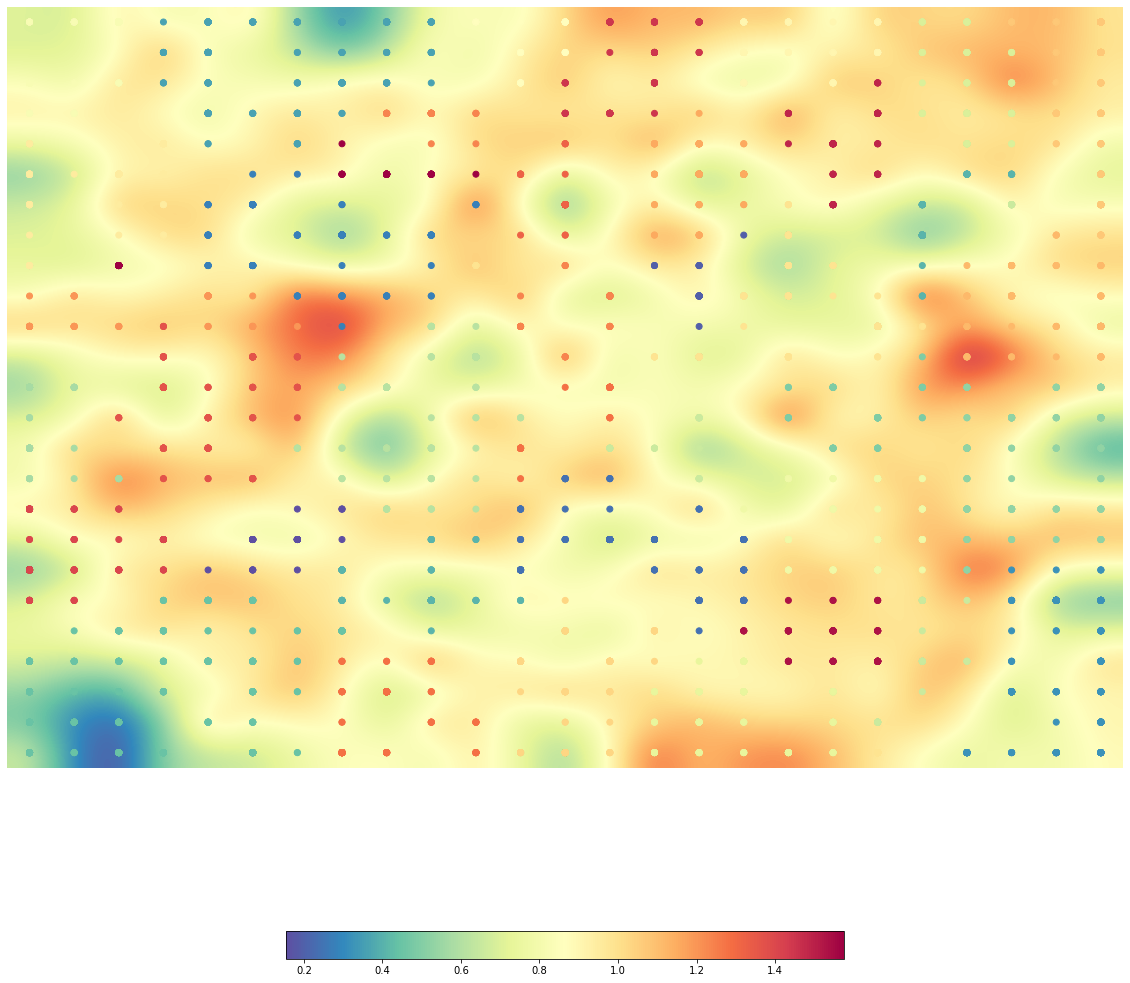

[[16 16 16  5  5  5  5  5  5  5 17 17 17 31 31 31 18 18 18 18 13 13 22 22
  22]
 [16 16 16  5  5  5  5  5  5  5 17 17 17 31 31 31 18 18 18 18 13 13 13 22
  22]
 [16 16 16  5  5  5  5  5  5  5 17 17 31 31 31 18 18 18 18 32 13 13 13 22
  22]
 [16 16 16  5  5  5  5  5 26 26 26 17 31 31 31 24 18 32 32 32 13 13 13 22
  22]
 [19 19 19 19  5  5  5 34 34 26 26 28 28 31 24 24 24 32 32 32 13 13 13 22
  22]
 [19 19 19 19 19  3  3 34 34 34 34 28 28 28 24 24 24 24 32 32  6  6  6 22
  22]
 [19 19 19 19  3  3  3  3 34 34  3 28 28 28 24 24 24 20 32 20  6  6 12 22
  22]
 [19 19 19 19  3  3  3  3  3  3  3 28 28 28 24 24  1 20 20  6  6  6  6 23
  22]
 [19 19 34 19  3  3  3  3  3  3 20 20 26 26  1  1 20 20 20 20  6 23 23 23
  23]
 [25 25 34 25 25 25  3  3  3  3 20 26 26 26 26  1 20 20 20 20  6 23 23 23
  23]
 [25 25 25 29 25 25 25  3 34 11 11 26 26 26 20  1 20 20 20 20 20 23 23 23
  23]
 [10 10 29 29 29 29 29 11 11 11 11 11 26 27 20 20 20 20 20 20  8 23 23 23
  23]
 [10 10 29 29 29 29 29 11 11 11 11 11 27

In [43]:
print("n_cols: ", n_cols)
print("n_rows: ", n_rows)
print("epochs: ", epochs)
print("k: ", k)

# print U-matrix
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(20,20))

# print all clusters
print(som.clusters)

# get the number of times each unique cluster occured
_ , no_of_neurons = np.unique(som.clusters, return_counts=True)

# sort the clusters according the times they occured
cluster_index = np.argsort(no_of_neurons)

print("Cluster Index:")
# print clusters sorted
print(cluster_index)

print("Number of Neurons:")
# print number of neurons for each cluster
print(no_of_neurons[cluster_index])


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

Η ουσία των συναρτήσεων που υλοποιήθηκαν είναι ίδια με αυτή στην περιγραφή της προτεινόμενης υλοποίησης, ωστόσο υπάρχουν μικρές διαφορές. Συγκεκριμένα, η 3η συνάρτηση *neuron_movies_report* δέχεται ως όρισμα ένα cluster, λαμβάνει μία λίστα από νευρώνες μέσω της 2ης συνάρτησης *print_cluster_neurons_movies_report* για το συγκεκριμένο cluster και στη συνέχεια για κάθε νευρώνα βρίσκει τις ταινίες που αντιστοιχούν σε αυτούς. Όλες οι ταινίες αυτές συγκεντρώνονται σε μία λίστα. Τέλος, καλείται η πρώτη συνάρτηση *print_categories_stats* με όρισμα αυτήν τη λίστα ταινιών και τυπώνει τις κατηγορίες και το πλήθος των φορών που εμφανίστηκαν σε αυτές τις ταινίες.

Επομένως, <u> η σημασιολογική ερμηνεία του χάρτη επιτελείται καλώντας την **neuron_movies_report** με τον αριθμό του cluster που μας ενδιαφέρει</u>.

In [129]:
from collections import Counter, OrderedDict


def print_categories_stats(movies, showResults=True):
    """
    Function that prints the categories and the times they occured
    for the list of ids of movies that are provided as parameters
    """
    # initialize list of all categories
    all_categories = []
    for movie in movies:
        # get list of categories for each movie
        movie_categories = [cat[1:-1] for cat in categories[movie][0].split(',  ')]
        # add categories to the total list
        all_categories.extend(movie_categories)
    
    # get a Counter dict that has as key the categories and as values the times they occured
    category_frequencies = Counter(all_categories)
    # sort the keys of the above dict according to the value 
    sorted_keys = [k for k, v in sorted(category_frequencies.items(), key=lambda item: item[1], reverse=True)]
    
    if showResults:
        print("Overall Cluster Genres stats:")
        # print dict according to the list of its sorted keys
        for k in sorted_keys:
            print("{: >30} : {: >20}".format(k, category_frequencies[k]))

    return sorted_keys



def print_cluster_neurons_movies_report(cluster):
    """
    Function that returns a list of bmus that correspond to the 
    given cluster.
    """
    # get coordinates of neurons that belong to the cluster
    coordinates = np.where(som.clusters == cluster)

    # get list of coordinates
    bmus = np.column_stack(coordinates)

    list_of_ubmus = [list(el) for el in ubmus]
    # get list of the indexes in ubmus list of each bmu
    bmus_list = [list_of_ubmus.index([bmu[1], bmu[0]]) for bmu in bmus if [bmu[1], bmu[0]] in list_of_ubmus]
    
    
    return bmus_list


def neuron_movies_report(cluster, showResults=True):
    """
    Function that prints the categories of the movies that
    correspond to the given cluster
    """
    
    # get list of neurons for the given cluster
    list_of_neurons = print_cluster_neurons_movies_report(cluster)
    movies = []
    # for each neuron of the list
    for neuron in list_of_neurons:
        # find the movies that are related to the neuron
        temp = np.where(indices == neuron) 
        for el in temp[0]:
            # add movies to the total list
            movies.append(el)
    # print the corresponding categories for all the movies of the cluster
    return print_categories_stats(movies, showResults)

Παρακάτω δοκιμάζουμε 3 clusters που βρίσκονται μακριά και κοντά στο χάρτη. Συγκεκριμένα, βλέπουμε από τα clusters που τυπώθηκαν ότι τα clusters 21 και 14 είναι κοντά μεταξύ τους και μακριά από το 17. Επομένως καλούμε τη συνάρτηση *neuron_movies_report* για τα 3 αυτά clusters.

In [131]:
neuron_movies_report(17);

Overall Cluster Genres stats:
                   Family Film :                   71
                        Comedy :                   71
                     Adventure :                   32
             Children's/Family :                   19
                     Animation :                   13
                         Drama :                   10
                          Teen :                    9
                        Action :                    9
                    Children's :                    7
                     Slapstick :                    7
     Family-Oriented Adventure :                    7
                        Sports :                    6
               Science Fiction :                    6
                       Fantasy :                    6
                 Coming of age :                    4
               Christmas movie :                    4
                Animal Picture :                    4
             Fantasy Adventure :                    

In [132]:
neuron_movies_report(21);

Overall Cluster Genres stats:
                 Crime Fiction :                  142
                         Drama :                  142
                      Thriller :                   48
                        Action :                   35
                       Mystery :                   23
                         Indie :                   18
                   Crime Drama :                   10
                     Film noir :                    8
                 Gangster Film :                    6
               Film adaptation :                    6
                  World cinema :                    5
                        Horror :                    5
                  Family Drama :                    5
              Television movie :                    5
                          Teen :                    5
                  Period piece :                    4
              Action/Adventure :                    4
                 Coming of age :                    

In [133]:
neuron_movies_report(14);

Overall Cluster Genres stats:
                 Crime Fiction :                  108
                      Thriller :                  101
                Crime Thriller :                   91
                         Drama :                   80
                       Mystery :                   58
               Black-and-white :                   32
                     Film noir :                   26
                     Detective :                   21
             Detective fiction :                   20
                      Suspense :                   19
                   Crime Drama :                   16
                  World cinema :                   15
        Psychological thriller :                   12
                         Indie :                   12
                        Action :                    9
                 Gangster Film :                    9
                        Comedy :                    9
               Film adaptation :                    

Όπως αναμενόταν, βλέπουμε ότι οι συχνότερες κατηγορίες για τα clusters που ήταν κοντά μεταξύ τους (21 και 14) είναι κοινές ενώ διαφέρουν κατά πολύ με τις πιο συχνά εμφανιζόμενες κατηγορίες του cluster 17.

<u>**Σημείωση**</u>

Με την παραπάνω διαδικασία μπορούμε να αναθέσουμε μία ή περισσότερες κατηγορίες ως ετικέτες κινηματογραφικού είδους στο κάθε cluster. Αρκεί να επιλέξουμε την πρώτη ή περισσότερες κατηγορίες από τις λίστες που τυπώνουμε και να τις αναθέσουμε σε κάθε cluster. Η υλοποίηση για αυτήν τη λειτουργία είναι η παρακάτω:

In [137]:
def label_clusters():
    
    
    # for every cluster
    for cluster in range(35):
        categories = neuron_movies_report(cluster, showResults=False)
        print("{: >10} : {: >20} {: >20}".format(cluster, categories[0], categories[1]))
        
        
    
label_clusters()

         0 :                Drama             War film
         1 :         Comedy-drama                Indie
         2 :                Drama             Thriller
         3 :      Romantic comedy               Comedy
         4 :           Short Film            Animation
         5 :               Comedy               Parody
         6 :               Action                Drama
         7 :                Drama                Indie
         8 :         World cinema               Horror
         9 :               Horror              Slasher
        10 :                Drama         World cinema
        11 :         Romance Film                Drama
        12 :             Thriller Psychological thriller
        13 :               Action     Action/Adventure
        14 :        Crime Fiction             Thriller
        15 :             Thriller               Horror
        16 :               Comedy      Black-and-white
        17 :          Family Film               Comedy
        

Παρατηρούμε, επομένως, ότι για κάθε cluster οι 2 κατηγορίες που του αντιστοιχούν είναι πολύ κοντινές μεταξύ τους. Η παρατήρηση αυτή μας οδηγεί στο συμπέρασμα ότι έχει γίνει καλή ομαδοποίηση.


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.




## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook (η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας).

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.



Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.


### Ανάλυση τοπολογικής ιδιότητας 1
Αναμένουμε κατηγορίες που έχουν μεγαλύτερη συχνότητα εμφάνισης στο χώρο εισόδου να τείνουν να απεικονίζονται με περισσότερους νευρώνες. Για την εξέταση της παραπάνω παρατήρησης υλοποιούμε την παρακάτω συνάρτηση που υπολογίζει το πλήθος των νευρώνων στο οποίο εμφανιζεται με συχνοτητα που να την τοποθετει στις στις top \<position> κατηγορίες. Την παραπάνω επιλογή την κάνουμε, καθώς θεωρούμε ότι ενας νευρώνας δεν αρκεί να έχει απλώς την κατηγορία για να θεωρείται οτι η κατηγορία χαρακτηριζει τον νευρωνα, αλλα πρέπει να εχει και μια σχετικά υψηλή συχνότητα στον νευρώνα αυτόν. Aν η τιμή της παραμέτρου πάρει πολύ μεγάλη τιμή, τότε η παράμετρος αυτή δε θα παίζει κάποιο ρόλο. Για το παραπάνω υλοποιούμε την παρακάτω συνάρτηση:

In [102]:
def categoryNeurons(category, position=5):
    """
    Function that returns the number of neurons the given
    category has occured in top <position> position.
    """
    
    num_of_neurons = 0
    all_neurons = range(n_cols*n_rows)
    for neuron in all_neurons:

        neuron_categories = []
        # get list of movies that correspond to the current neuron
        neuron_movies =np.where(indices==neuron)
        
        for movie in neuron_movies[0]:
            # get a set of the categories of the current movie
            movie_categories = [cat[1:-1] for cat in categories[movie][0].split(',  ')]
            # add to list of all categories of the neuron
            neuron_categories.extend(movie_categories)

        # get a counter of all the categories of the neuron
        n_cat_counter = Counter(neuron_categories)

        # sort categories based on frequency
        sorted_keys = [k for k, v in sorted(n_cat_counter.items(), key=lambda item: item[1], reverse=True)]
        
        # if category occured and if it is in top <position> position according to the times it occured
        if category in n_cat_counter.keys() and sorted_keys.index(category) <= position:
            num_of_neurons +=1


    print("Category \033[1m", category, "\033[0m has occured in top ", position, " positions in ", '\033[1m',num_of_neurons,'\033[0m', 'neurons.')


categoryNeurons('Thriller', position=5)

Category  Thriller  has occured in top  5  positions in   115  neurons.


Έχοντας υλοποιήσει την παραπάνω συνάρτηση θα την καλέσουμε για τις 10 συχνότερες κατηγορίες των ταινιών μας.
Αυτές μπορούμε να τις βρούμε από την ήδη υλοποιημένη συνάρτηση print_categories_stats(movies):

In [138]:
all_movies = range(5000)
sorted_keys = print_categories_stats(all_movies, showResults=False)

for category in sorted_keys[:10]:
    categoryNeurons(category, position=5)

Category  Drama  has occured in top  5  positions in   221  neurons.
Category  Comedy  has occured in top  5  positions in   128  neurons.
Category  Thriller  has occured in top  5  positions in   115  neurons.
Category  Romance Film  has occured in top  5  positions in   101  neurons.
Category  Action  has occured in top  5  positions in   82  neurons.
Category  World cinema  has occured in top  5  positions in   79  neurons.
Category  Crime Fiction  has occured in top  5  positions in   74  neurons.
Category  Black-and-white  has occured in top  5  positions in   71  neurons.
Category  Horror  has occured in top  5  positions in   67  neurons.
Category  Action/Adventure  has occured in top  5  positions in   52  neurons.


Με διαφορετική τιμή position:

In [139]:
all_movies = range(5000)
sorted_keys = print_categories_stats(all_movies, showResults=False)

for category in sorted_keys[:10]:
    categoryNeurons(category, position=1)

Category  Drama  has occured in top  1  positions in   118  neurons.
Category  Comedy  has occured in top  1  positions in   47  neurons.
Category  Thriller  has occured in top  1  positions in   90  neurons.
Category  Romance Film  has occured in top  1  positions in   56  neurons.
Category  Action  has occured in top  1  positions in   30  neurons.
Category  World cinema  has occured in top  1  positions in   25  neurons.
Category  Crime Fiction  has occured in top  1  positions in   45  neurons.
Category  Black-and-white  has occured in top  1  positions in   20  neurons.
Category  Horror  has occured in top  1  positions in   44  neurons.
Category  Action/Adventure  has occured in top  1  positions in   34  neurons.


Αντίστοιχα θα εκτελέσουμε τα παραπάνω για τις 10 πιο σπάνιες κατηγορίες των ταινιών μας:

In [55]:
for category in sorted_keys[-10:]:
    categoryNeurons(category, position=5)

Category  Steampunk  has occured in top  5  positions in   1  neurons.
Category  Instrumental Music  has occured in top  5  positions in   1  neurons.
Category  Interpersonal Relationships  has occured in top  5  positions in   1  neurons.
Category  Family & Personal Relationships  has occured in top  5  positions in   1  neurons.
Category  Reboot  has occured in top  5  positions in   1  neurons.
Category  Czechoslovak New Wave  has occured in top  5  positions in   1  neurons.
Category  Film-Opera  has occured in top  5  positions in   1  neurons.
Category  Roadshow/Carny  has occured in top  5  positions in   1  neurons.
Category  Exploitation  has occured in top  5  positions in   1  neurons.
Category  Heaven-Can-Wait Fantasies  has occured in top  5  positions in   1  neurons.


Aπο τα παραπάνω συμπεραίνουμε ότι οι πιο συχνές κατηγορίες εμφανίζονται ως top 5 κατηγορίες σε πολλούς νευρώνες, ενώ οι σπάνιες κατηγορίες σε ελάχιστους (μόνο έναν). Επομένως, επαληθεύεται η πρώτη τοπολογική ιδιότητα του SOM

### Ανάλυση τοπολογικής ιδιότητας 2
Στη συνέχεια, θα εξετάσουμε την απόσταση δύο μη σχετικών προτύπων εισόδου στον χάρτη. Αυτό θα γίνει επιλέγοντας κατηγορίες ταινιών που είναι μακρινές μεταξύ τους και βλέποντας τη θέση των νευρώνων στους οποίους αντιστοιχούν. Για τον σκοπό αυτό υλοποιούμε την παρακάτω συνάρτηση:

In [108]:
def plot_neurons(neurons_1, neurons_2, category_1, category_2):
    """
    Function that plots the position of the neurons of the 
    two categories
    * neurons_1: list of neurons of category 1
    * neurons_2: list of neurons of category 2
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    x_axes_1 = [n[0] for n in neurons_1]
    y_axes_1 = [n[1] for n in neurons_1]
    
    x_axes_2 = [n[0] for n in neurons_2]
    y_axes_2 = [n[1] for n in neurons_2]
    
    ax.scatter(x_axes_1, y_axes_1, c='blue', label=category_1,
               alpha=0.3, s=40, edgecolors='none')
    ax.scatter(x_axes_2, y_axes_2, c='red', label=category_2,
               alpha=0.3, s=40, edgecolors='none')
    
    
    ax=plt.gca()                            # get the axis
    ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
    ax.xaxis.tick_top()                     # and move the X-Axis         
    plt.xticks(range(25))
    plt.yticks(range(25))
    ax.yaxis.tick_left() 
    ax.legend()
    plt.show()

def categories_distances(category_1, category_2, position=10000):
    """
    Function that show the distance of the neurons in the map of the
    two categories.
    """
    
    cat1_neurons = set()
    cat2_neurons = set()
    
    all_neurons = range(n_cols*n_rows)
    for neuron in all_neurons:
        
        neuron_categories = []
        
        # get list of movies that correspond to the current neuron
        neuron_movies =np.where(indices==neuron)
        
        for movie in neuron_movies[0]:
            # get a set of the categories of the current movie
            movie_categories = set([cat[1:-1] for cat in categories[movie][0].split(',  ')])
            
            neuron_categories.extend(movie_categories)

        
        # get a counter of all the categories of the neuron
        n_cat_counter = Counter(neuron_categories)
        # sort categories based on frequency
        sorted_keys = [k for k, v in sorted(n_cat_counter.items(), key=lambda item: item[1], reverse=True)]
        
        if category_1 in n_cat_counter.keys() and sorted_keys.index(category_1) <= position:
            cat1_neurons.add((ubmus[neuron][0], ubmus[neuron][1]))
        
        if category_2 in n_cat_counter.keys() and sorted_keys.index(category_2) <= position:
            cat2_neurons.add((ubmus[neuron][0], ubmus[neuron][1]))
        
        
    intersection = cat1_neurons.intersection(cat2_neurons)
    
    print("cat1_neurons: ", cat1_neurons)
    print("cat2_neurons: ", cat2_neurons)
    print("intersection: ", intersection)
    
    plot_neurons(cat1_neurons, cat2_neurons, category_1, category_2)
    
    if len(intersection) == 0 and len(cat1_neurons) == 1 and len(cat2_neurons) == 1:
        n1 = cat1_neurons.pop()
        print(n1)
        n2 = cat2_neurons.pop()
        print(n2)
        manhattan_distance = abs(n1[0]-n2[0]) + abs(n1[1]-n2[1])
        print("manhattan_distance: ", manhattan_distance)
    

In [91]:
a = [1,2,1,3,1,3,1,8,6,6,6]
ac = Counter(a)
sorted_keys = [k for k, v in sorted(ac.items(), key=lambda item: item[1], reverse=True)]
print(ac)
print(sorted_keys)

Counter({1: 4, 6: 3, 3: 2, 2: 1, 8: 1})
[1, 6, 3, 2, 8]


cat1_neurons:  {(15, 7)}
cat2_neurons:  {(2, 24)}
intersection:  set()


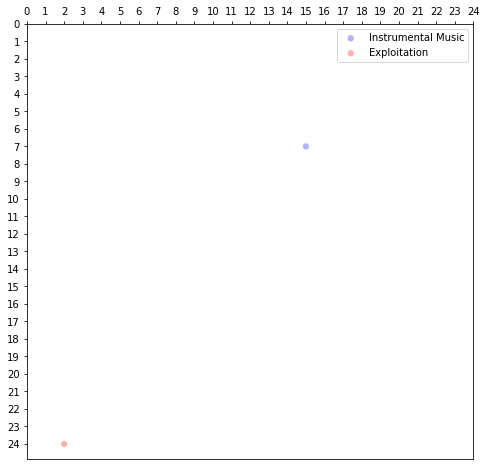

(15, 7)
(2, 24)
manhattan_distance:  30


In [109]:
categories_distances("Instrumental Music", "Exploitation")

cat1_neurons:  {(18, 23), (22, 5), (12, 22), (14, 22), (9, 11), (10, 15), (19, 24), (10, 24), (13, 23), (15, 23), (18, 22), (12, 24), (14, 21), (19, 23), (10, 23), (13, 22), (21, 5), (12, 23), (12, 20), (14, 20), (9, 15), (24, 3), (11, 21), (7, 2), (11, 24), (13, 21), (13, 24)}
cat2_neurons:  {(11, 1), (12, 4), (0, 4), (11, 0), (14, 1), (22, 24), (13, 0), (12, 3), (4, 21), (11, 2), (10, 0), (13, 3), (12, 2), (14, 2), (23, 24)}
intersection:  set()


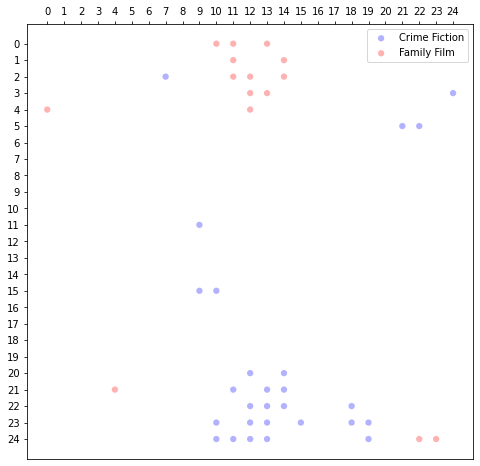

In [112]:
categories_distances("Crime Fiction", "Family Film", position=1)

cat1_neurons:  {(18, 21), (17, 20), (13, 23), (18, 20), (14, 23), (19, 20), (15, 23), (18, 19), (18, 22), (17, 21), (15, 22), (14, 18), (19, 21)}
cat2_neurons:  {(15, 5), (14, 4), (1, 21), (15, 4), (14, 7), (15, 7), (11, 22), (16, 6), (14, 6), (24, 19), (14, 3), (15, 6), (16, 5), (15, 3), (16, 4), (14, 5)}
intersection:  set()


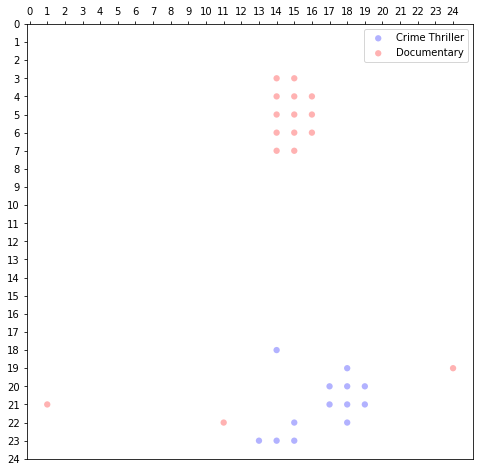

In [115]:
categories_distances("Crime Thriller", "Documentary", position=1)

Επιλέγοντας ως δύο κατηγορίες τις σπάνιες και διαφορετικές μεταξύ τους κατηγορίες: *Instrumental Music* και *Exploitation* προκύπτει ότι απέχουν πολύ μακριά η μία με την άλλη στο χάρτη SOM, ενώ δεν αντιστοιχούν σε κανέναν κοινό νευρώνα. Έχουμε θέσει τη default τιμή για το position ώστε να μην επηρεάζει, καθώς είναι σίγουρο ότι αυτές οι κατηγορίες δε θα βρίσκονται στις τοπ θέσεις.

Στη δεύτερη περίπτωση επιλέγεται δύο πολύ συχνές κατηγορίες: "Crime Fiction" και μία διαφορετική: "Family Film". Eπειδή είναι συχνές ως κατηγορίες θέτουμε position=1 για να βρούμε τους νευρώνες που κυριαρχούν. Το αποτέλεσμα είναι η πρώτη να αντιστοιχεί σε πολλούς κόμβους κάτω και στο κέντρο του χάρτη, ενώ η δεύτερη πάνω και στο κέντρο, με κάποιες πάντα εξαιρέσεις. Η τομή των δύο είναι πάλι μηδενική.

Στην τρίτη ακολουθάμε ένα παρόμοιο μοτίβο και καταλήγουμε στα ίδια.

Επομένως, επαληθεύεται ότι μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη.

### Ανάλυση τοπολογικής ιδιότητας 3
Τέλος, θα εξετάσουμε την απόσταση δύο κοντινών προτύπων εισόδου στον χάρτη. Αυτό θα γίνει επιλέγοντας κατηγορίες ταινιών που είναι κοντινές μεταξύ τους και βλέποντας τη θέση των νευρώνων στους οποίους αντιστοιχούν. Για τον σκοπό αυτό η συνάρτηση που υλοποιήθηκε παραπάνω:

cat1_neurons:  {(23, 4), (20, 11), (22, 2), (4, 0), (12, 1), (3, 4), (4, 3), (4, 9), (3, 7), (8, 0), (9, 5), (0, 2), (5, 10), (8, 3), (8, 9), (0, 5), (2, 2), (10, 0), (10, 3), (11, 2), (11, 5), (7, 4), (6, 2), (7, 1), (7, 7), (6, 5), (24, 23), (21, 3), (12, 0), (22, 4), (4, 2), (23, 3), (5, 0), (5, 3), (8, 2), (20, 22), (9, 1), (9, 7), (8, 5), (19, 11), (11, 1), (1, 2), (6, 1), (2, 10), (7, 0), (24, 16), (6, 4), (7, 9), (6, 7), (21, 2), (7, 6), (22, 3), (21, 4), (4, 1), (4, 7), (9, 0), (5, 5), (9, 3), (0, 0), (5, 8), (8, 1), (8, 7), (0, 3), (2, 0), (10, 4), (11, 0), (0, 6), (7, 2), (6, 0), (7, 5), (6, 3), (6, 9)}
cat2_neurons:  {(11, 1), (12, 4), (0, 4), (11, 0), (14, 1), (22, 24), (13, 0), (12, 3), (4, 21), (11, 2), (10, 0), (13, 3), (12, 2), (14, 2), (23, 24)}
intersection:  {(11, 1), (11, 2), (10, 0), (11, 0)}


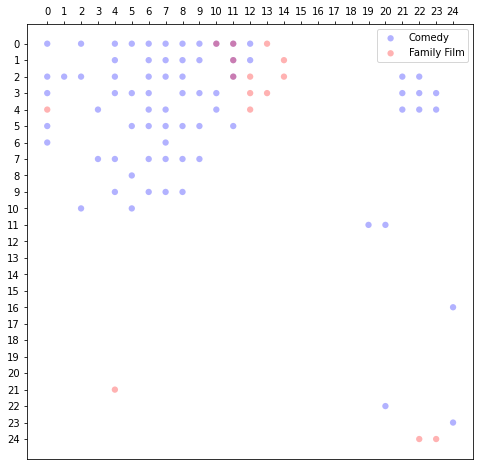

In [116]:
categories_distances("Comedy", "Family Film", position=1)

cat1_neurons:  {(18, 23), (22, 5), (12, 22), (14, 22), (9, 11), (10, 15), (19, 24), (10, 24), (13, 23), (15, 23), (18, 22), (12, 24), (14, 21), (19, 23), (10, 23), (13, 22), (21, 5), (12, 23), (12, 20), (14, 20), (9, 15), (24, 3), (11, 21), (7, 2), (11, 24), (13, 21), (13, 24)}
cat2_neurons:  {(19, 24), (16, 20), (17, 21), (18, 23), (16, 19), (18, 16), (14, 20), (22, 4), (16, 22), (15, 20), (16, 21), (15, 19), (18, 18), (16, 18), (20, 22), (17, 24), (17, 8), (20, 21)}
intersection:  {(19, 24), (14, 20), (18, 23)}


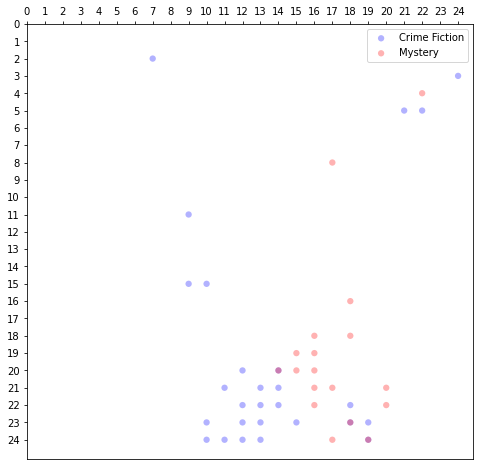

In [117]:
categories_distances("Crime Fiction", "Mystery", position=1)

Και στις δύο περιπτώσεις έχουμε πάρει δύο κοντινές κατηγορίες και έχουμε θέσει position=1 για να βρούμε τους κόμβους που κυριαρχούν. Όπως φαίνεται και στα δύο αποτελέσματα οι κατηγορίες αυτές βρίσκονται σε γειτονικούς κόμβους.

Επομένως, επαληθεύεται ότι <u>κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη</u>.

# Επιπλέον σημειώσεις

Με χρήση της παραπάνω διαδικασίας είδαμε επίσης πού βρίσκονται μέσα στο χάρτη U-matrix οι νευρώνες στους οποίους αντιστοιχούν οι διάφορες κατηγορίες. Για παράδειγμα η κατηγορία Comedy βρίσκεται πάνω αριστερά, ενώ δίπλα της η κοντινή της Family Film. Η Crime Fiction βρίσκεται κάτω και στο κέντρο, ενώ λίγο αριστερά οι κοντινές της Crime Thriller και Mystery.

H διαδικασία αυτή μπορεί να επαναληφθεί για οποιαδήποτε κατηγορία ενώ με αλλαγή της παραμέτρου position μπορούμε να κάνουμε τα όρια πιο χαλαρά ή όχι, θέτοντας πόσο ψηλά στην κατάταξη των κατηγοριών του νευρώνα θα βρίσκεται η κατηγορία που μας ενδιαφέρει.


# Τελική παράδοση άσκησης

- Θα παραδώσετε στο eclass το παρόν notebook επεξεργασμένο ή ένα νέο με τις απαντήσεις σας για τα ζητούμενα και των δύο εφαρμογών. 
- Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στον τελικό χάρτη με τα κελιά ορατά που θα παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας. 
- Μην ξεχάσετε στην αρχή ένα κελί markdown με **τα στοιχεία της ομάδας σας**.
- Στο **zip** που θα παραδώσετε πρέπει να βρίσκονται **2 αρχεία (το .ipynb και το .py του notebook σας)**.

<table>
  <tr><td align="center">
    <font size="4">Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα!</font>
</td>
  </tr>
</table>